# Сегментация тетрадей

## Detectron2 baseline

В данном ноутбуке представлен baseline модели сегментации текста в школьных тетрадях с помощью фреймворка detectron2. Вы можете (и это даже лучше) использовать другие модели (например UNET, mmdet), или написать полностью свою.

# 0. Установка библиотек

Установка библиотек, под которым запускается данный бейзлайн.

In [1]:
!nvidia-smi

Fri Mar  4 08:47:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:E0:00.0 Off |                    0 |
| N/A   28C    P0    49W / 350W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nproc

3


In [3]:
# !python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

## 1. Загрузить необходимые библиотеки для создания и обучения модели

In [1]:
import cv2
import random
import json
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil

import tqdm
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["figure.dpi"] = 120

In [2]:
import torch, torchvision
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog,DatasetCatalog
from detectron2.data.datasets import register_coco_instances,load_coco_json
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultTrainer
from detectron2.engine import HookBase

# from detectron2.utils.logger import setup_logger
# setup_logger()

import logging
logger = logging.getLogger('detectron2')
logger.setLevel(logging.CRITICAL)

Прежде чем переходить к загрузке данных посмотрим, доступны ли нам GPU-мощности. 

In [3]:
print('GPU: ' + str(torch.cuda.is_available()))

GPU: True


# 3. Регистрация датасета

Зарегистрируем выборки в detectron2 для дальнейшей подачи на обучение модели.

In [4]:
for d in ['train','val']:
    DatasetCatalog.register("my_dataset_"+d, lambda d=d: load_coco_json("train_segmentation/annotations_{}.json".format(d),
    image_root= "train_segmentation/images",\
    dataset_name="my_dataset_"+d,extra_annotation_keys=['bbox_mode']))

После регистрации можно загружать выборки, чтобы иметь возможность посмотреть на них глазами. Первой загрузим обучающую выборку в **dataset_dicts_train**

In [5]:
dataset_dicts_train = DatasetCatalog.get("my_dataset_train")
train_metadata = MetadataCatalog.get("my_dataset_train")

И тестовую выборку в **dataset_dicts_val**

In [6]:
dataset_dicts_val = DatasetCatalog.get("my_dataset_val")
val_metadata = MetadataCatalog.get("my_dataset_val")

Посмотрим на размер получившихся выборок - эта операция в python осуществляется при помощи функции **len()**

In [7]:
print('Размер обучающей выборки (Картинки): {}'.format(len(dataset_dicts_train)))
print('Размер тестовой выборки (Картинки): {}'.format(len(dataset_dicts_val)))

Размер обучающей выборки (Картинки): 854
Размер тестовой выборки (Картинки): 78


Итак, у нас в распоряжении 588 изображения для тренировки, и 66 - для проверки качества.

**Посмотрим на размеченные фотографии из валидации**

In [8]:
import os
from IPython.display import Image
@interact
def show_images(file=range(len(dataset_dicts_val))):
    example = dataset_dicts_val[file]
    image = utils.read_image(example["file_name"], format="RGB")
    plt.figure(figsize=(3,3),dpi=200)
    visualizer = Visualizer(image[:, :, ::-1], metadata=val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(example)
    plt.imshow(vis.get_image()[:, :,::-1])
    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

##   4 Обучение модели

**4.1. Определяем конфигурацию**

Прежде чем начать работать с самой моделью, нам нужно определить ее параметры и спецификацию обучения

Создаем конфигурацию и загружаем архитектуру модели с предобученными весами (на COCO - датасете, содержащем $80$ популярных категорий объектов и более $300000$ изображений) для распознавания объектов.

In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) 
cfg.MODEL.WEIGHTS = 'output3/model_0000999.pth' # model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")

В целом, вы можете посмотреть и другие архитектуры в зоопарке [моделей](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

Теперь задаем параметры самой модели и обучения модели

In [10]:
# Загружаем названия обучающией и тестовой выборок в настройки
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

# Часто имеет смысл сделать изображения чуть меньшего размера, чтобы 
# обучение происходило быстрее. Поэтому мы можем указать размер, до которого будем изменяться наименьшая 
# и наибольшая из сторон исходного изображения.
cfg.INPUT.MIN_SIZE_TRAIN = 800
cfg.INPUT.MAX_SIZE_TRAIN = 1333

cfg.INPUT.MIN_SIZE_TEST = 800
cfg.INPUT.MAX_SIZE_TEST = 1333

# Также мы должны сказать модели ниже какой вероятности определения она игнорирует результат. 
# То есть, если она найдет на картинке еду, но вероятность правильного определения ниже 0.5, 
# то она не будет нам сообщать, что она что-то нашла.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2

# Также мы должны указать порядок каналов во входном изображении. Обратите внимание, что это Blue Green Red (BGR), 
# а не привычный RGB. Это особенности работы данной модели.
cfg.INPUT.FORMAT = 'BGR' 

# Для более быстрой загрузки данных в модель, мы делаем параллельную загрузку. Мы указываем параметр 4, 
cfg.DATALOADER.NUM_WORKERS = 6

# Следующий параметр задает количество изображений в батче, на котором 
# модель делает одну итерацию обучения (изменения весов).
cfg.SOLVER.IMS_PER_BATCH = 12

# Зададим также learning_rate
# cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.SOLVER.BASE_LR = 1e-2
# cfg.SOLVER.BASE_LR_END = 1e-6
cfg.SOLVER.WARMUP_ITERS = 200

# Укажем модели, через сколько шагов обучения модели следует уменьшить learning rate
cfg.SOLVER.STEPS = (1000,2000)

# Фактор, на который уменьшается learning rate задается следующим выражением
cfg.SOLVER.GAMMA = 0.1

# Зададим общее число итераций обучения.
cfg.SOLVER.MAX_ITER = 3000

# Укажем количество классов в нашей выборке
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# Задаем через сколько  шагов обучения сохранять веса модели в файл. Этот файл мы сможем загрузить потом 
# для тестирования нашей обученной модели на новых данных.
cfg.SOLVER.CHECKPOINT_PERIOD = 500

# cfg.TEST.EVAL_PERIOD = 1000
cfg.TEST.DETECTIONS_PER_IMAGE = 1000

# И указываем название папки, куда сохранять чекпойнты модели и информацию о процессе обучения.
cfg.OUTPUT_DIR = './output4'

# Если вдруг такой папки нет, то создадим ее
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Если мы хотим удалить чекпойнты предыдущих моделей, то выполняем данную команду. 
#%rm output/*

## Custome augmentations

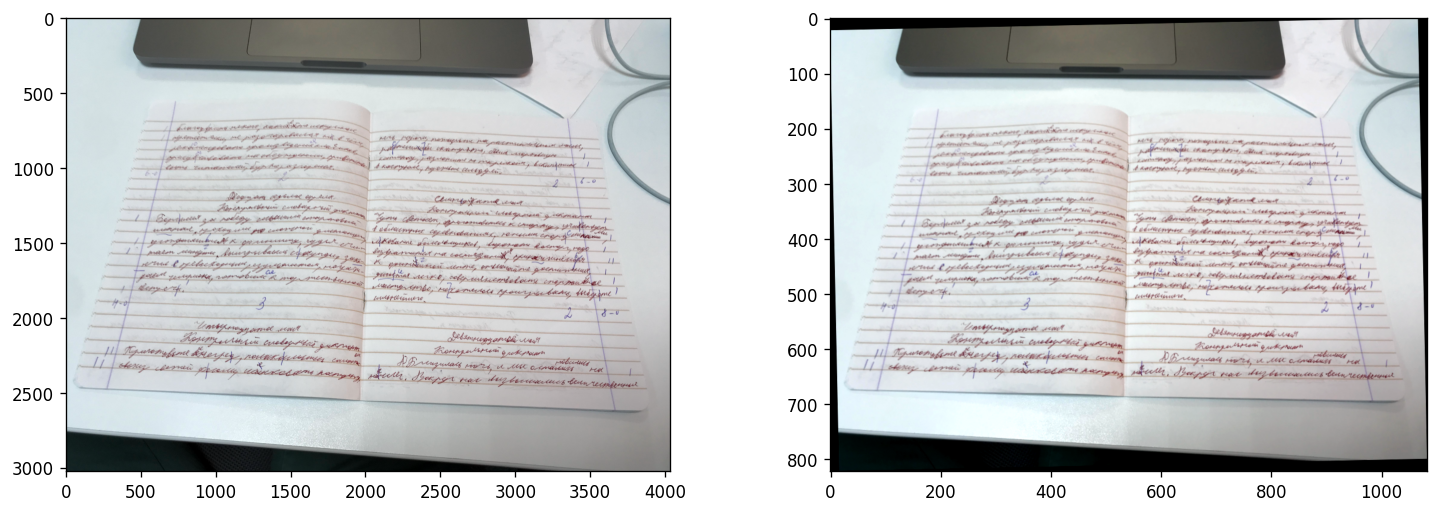

In [11]:
from detectron2.data import transforms as T

augs = T.AugmentationList([
    T.ResizeShortestEdge(short_edge_length=(cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN), max_size=cfg.INPUT.MAX_SIZE_TRAIN),
    T.RandomRotation([-4.0, 4.0]),
    T.RandomContrast(0.8, 1.2),
    T.RandomBrightness(0.8, 1.2),
    T.RandomLighting(0.7)
])

image = cv2.imread('train_segmentation/images/3_8.JPG')
inp = T.AugInput(image)

augs(inp)
image_transformed = inp.image

plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(image_transformed)
plt.show()

In [12]:
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper, build_detection_train_loader


class CustomeTrainer(DefaultTrainer):
    def build_train_loader(self, cfg):
        return build_detection_train_loader(cfg,
           mapper=DatasetMapper(cfg, is_train=True, augmentations=[
               T.ResizeShortestEdge(short_edge_length=(cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN), max_size=cfg.INPUT.MAX_SIZE_TRAIN),
               T.RandomRotation([-4.0, 4.0]),
               T.RandomContrast(0.8, 1.2),
               T.RandomBrightness(0.8, 1.2),
               T.RandomLighting(0.7)
           ])
        )

trainer = CustomeTrainer(cfg)

[03/04 09:57:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

2022-03-04 09:57:42.520738: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


**4.2. Обучаем модель**

Процесс обучения модели запускают следующие три строчки кода. Возможно будут предупреждения, на которые можно не обращать внимания, это информация об обучении.

In [13]:
torch.cuda.empty_cache()

trainer.resume_or_load(resume=False)
trainer.train()

[03/04 09:57:44 d2.engine.train_loop]: Starting training from iteration 0
[03/04 09:58:51 d2.utils.events]:  eta: 2:45:28  iter: 19  total_loss: 0.8805  loss_cls: 0.1485  loss_box_reg: 0.2696  loss_mask: 0.2384  loss_rpn_cls: 0.03208  loss_rpn_loc: 0.188  time: 3.1010  data_time: 0.9098  lr: 0.00095905  max_mem: 24036M
[03/04 09:59:55 d2.utils.events]:  eta: 2:41:24  iter: 39  total_loss: 0.866  loss_cls: 0.1509  loss_box_reg: 0.2676  loss_mask: 0.2317  loss_rpn_cls: 0.02918  loss_rpn_loc: 0.1928  time: 3.1436  data_time: 0.7919  lr: 0.0019581  max_mem: 24036M
[03/04 10:00:58 d2.utils.events]:  eta: 2:41:06  iter: 59  total_loss: 0.8468  loss_cls: 0.1466  loss_box_reg: 0.2689  loss_mask: 0.2262  loss_rpn_cls: 0.0305  loss_rpn_loc: 0.1747  time: 3.1429  data_time: 0.7421  lr: 0.0029571  max_mem: 24036M
[03/04 10:02:00 d2.utils.events]:  eta: 2:41:04  iter: 79  total_loss: 0.8731  loss_cls: 0.1484  loss_box_reg: 0.2693  loss_mask: 0.2355  loss_rpn_cls: 0.0294  loss_rpn_loc: 0.1853  time: